[Ссылка на соревнование](https://www.kaggle.com/c/nlp-getting-started)

In [1]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle
!kaggle competitions download -c nlp-getting-started
#%%capture
!pip install pymorphy2 transformers
!pip install text_hammer

# ! unzip "items.csv.zip"
# ! pip install catboost
# ! pip install -U pandas-profiling

  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 9.29MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 29.7MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 62.2MB/s]
     |████████████████████████████████| 55 kB 2.4 MB/s 
     |████████████████████████████████| 3.5 MB 4.8 MB/s 
     |████████████████████████████████| 8.2 MB 6.5 MB/s 
     |████████████████████████████████| 895 kB 36.5 MB/s 
     |████████████████████████████████| 67 kB 4.5 MB/s 
     |████████████████████████████████| 596 kB 34.5 MB/s 
     |████████████████████████████████| 6.8 MB 29.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 115 kB 5.2 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud
import text_hammer as th
from sklearn.metrics import confusion_matrix

In [3]:
from collections import defaultdict
import re
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from tqdm.auto import tqdm

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
sns.set_style(style='whitegrid')
device_num = 0

In [4]:
import torch
from torch import nn
from torch.utils.data import (
    TensorDataset, DataLoader, RandomSampler, SequentialSampler
)
from torchsummary import summary

import nltk
import pymorphy2
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertModel, BertForSequenceClassification

from keras.preprocessing.sequence import pad_sequences

In [5]:
nltk.download('punkt')
nltk.download("stopwords")
device = f"cuda:{device_num}" if torch.cuda.is_available() else "cpu"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [7]:
train.keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [8]:
train.location.unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

In [9]:
train['target'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

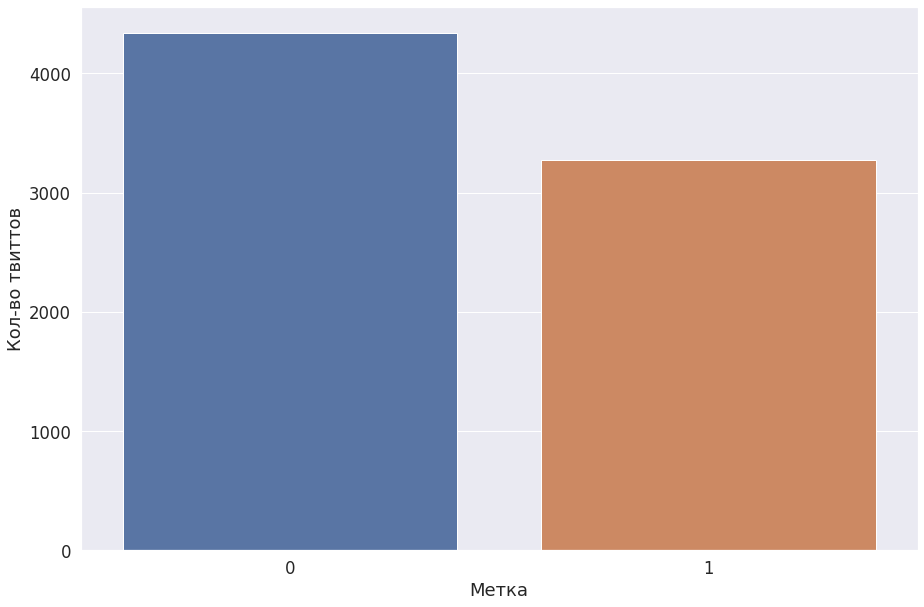

In [10]:
plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)

g = sns.countplot(
    data=train,
    x='target',
    )
g.set(ylabel='Кол-во твиттов', xlabel='Метка')
plt.savefig( "Twets_qunantity.png")
plt.show()

In [11]:
real_tweets = train[train['target']==1]['text']
fake_tweets = train[train['target']==0]['text']

In [12]:
num_tweets = 5
random_real_tweets = real_tweets.sample(num_tweets, random_state=42).values
random_fake_tweets = fake_tweets.sample(num_tweets, random_state=42).values


print('Real tweets:\n')
for i, tweet in enumerate(random_real_tweets):
    print('[{0}] {1}\n'.format(i+1, tweet))

print('-'*90)

print('Fake tweets:\n')
for i, tweet in enumerate(random_fake_tweets):
    print('[{0}] {1}\n'.format(i+1, tweet))

Real tweets:

[1] Nearly 50 thousand people affected by floods in #Paraguay ? http://t.co/aw23wXtyjB http://t.co/ABgct9VFUa

[2] Vladimir Putin Issues Major Warning But Is It Too Late To Escape Armageddon?
http://t.co/gBxafy1m1C

[3] @DoctorFluxx @StefanEJones @spinnellii @themermacorn  No burning buildings and rob during a riot. That's embarrassing &amp; ruining this nation.

[4] Telnet attacked from 124.13.172.40 (STREAMYX-HOME-SOUTHERN MY)

[5] LONDON IS DROWNING AND IIII LIVE BY THE RIVEEEEEER

------------------------------------------------------------------------------------------
Fake tweets:

[1] Everyday is a near death fatality for me on the road. Thank god is on my side.??

[2] #Lifestyle Û÷It makes me sickÛª: Baby clothes deemed a Û÷hazardÛª http://t.co/0XrfVidxA2 http://t.co/oIHwgEZDCk

[3] @Lenn_Len Probably. We are inundated with them most years!

[4] A demoness with the voice of an angel. Like a siren's call beckoning me to the void. Don't ?? on thisÛ_ https://t.c

In [13]:
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_urls(x))
    #df[column] = df[column].progress_apply(lambda x: th.remove_stopwords(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

In [14]:
train_cleaned_data = text_preprocessing(train,'text')

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

In [15]:
train_cleaned_data[train_cleaned_data.target == 1]

,id,keyword,location,text,target
0,1,NaN,NaN,our deed are the reason of this earthquake may...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all resident ask to shelter in place are being...,1
3,6,NaN,NaN,13000 people receive wildfire evacuation order...,1
4,7,NaN,NaN,just get send this photo from ruby alaska as s...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant crane hold a bridge collapse into ne...,1
7609,10870,NaN,NaN,aria_ahrary thetawniest the out of control wil...,1
7610,10871,NaN,NaN,m194 0104 coordinate universal time5 km s of v...,1
7611,10872,NaN,NaN,police investigate after an ebike collide with...,1


In [16]:
test_cleaned_data = text_preprocessing(test,'text')

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

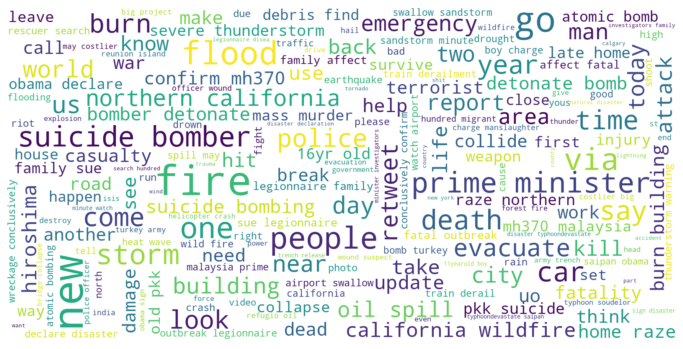

In [17]:
#Disaster Tweets wordcloud 
stop_words = set(stopwords.words('english'))
train_cleaned_data['text'] = train_cleaned_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

disaster_tweets = train[train.target == 1]
disaster_string = []
for t in disaster_tweets.text:
    disaster_string.append(t)
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
f = plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig( "worldcloud_wDis.png")
plt.show()

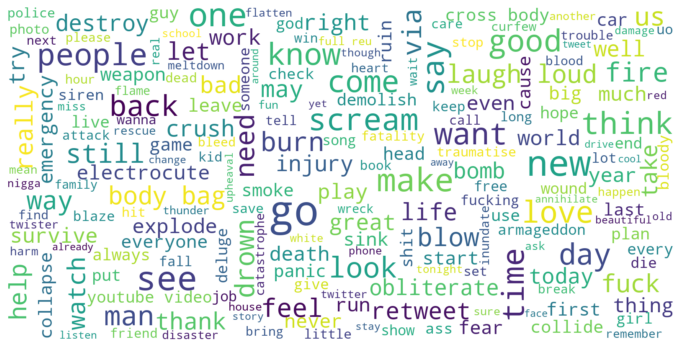

In [18]:
#Positive Tweets wordcloud 
stop_words = set(stopwords.words('english'))
train_cleaned_data['text'] = train_cleaned_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

disaster_tweets = train[train.target == 0]
disaster_string = []
for t in disaster_tweets.text:
    disaster_string.append(t)
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
f = plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig( "worldcloud_woDis.png")
plt.show()

In [19]:
train['len_text'] = train['text'].apply(len)
test['len_text'] = test['text'].apply(len)
train.head(5)

,id,keyword,location,text,target,len_text
0,1,NaN,NaN,deed reason earthquake may allah forgive us,1,43
1,4,NaN,NaN,forest fire near la ronge sask canada,1,37
2,5,NaN,NaN,resident ask shelter place notify officer evac...,1,79
3,6,NaN,NaN,13000 people receive wildfire evacuation order...,1,57
4,7,NaN,NaN,get send photo ruby alaska smoke wildfire pour...,1,53


In [20]:
train.groupby(['target'])['len_text'].describe().T

target,0,1
count,4342.000000,3271.000000
mean,58.417780,67.575359
std,24.925432,22.640490
min,3.000000,7.000000
25%,38.000000,51.000000
50%,59.000000,68.000000
75%,77.000000,84.000000
max,131.000000,137.000000


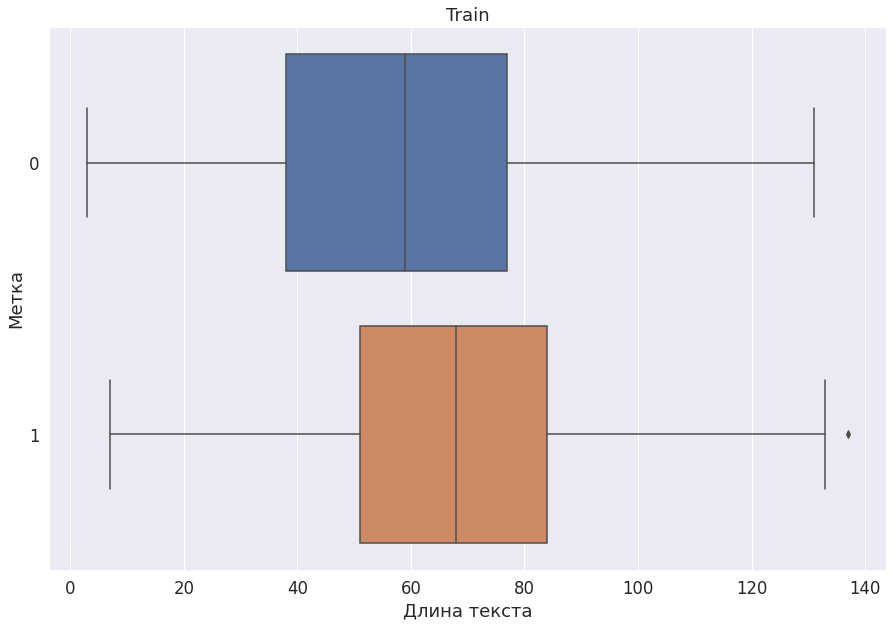

In [21]:
plt.figure(figsize=(15,10))
g = sns.boxplot(data=train, x='len_text', y='target', orient='h')
g.set(xlabel='Длина текста', ylabel='Метка')
g.set_title("Train")
plt.savefig( "boxplot_Train.png")
plt.show()

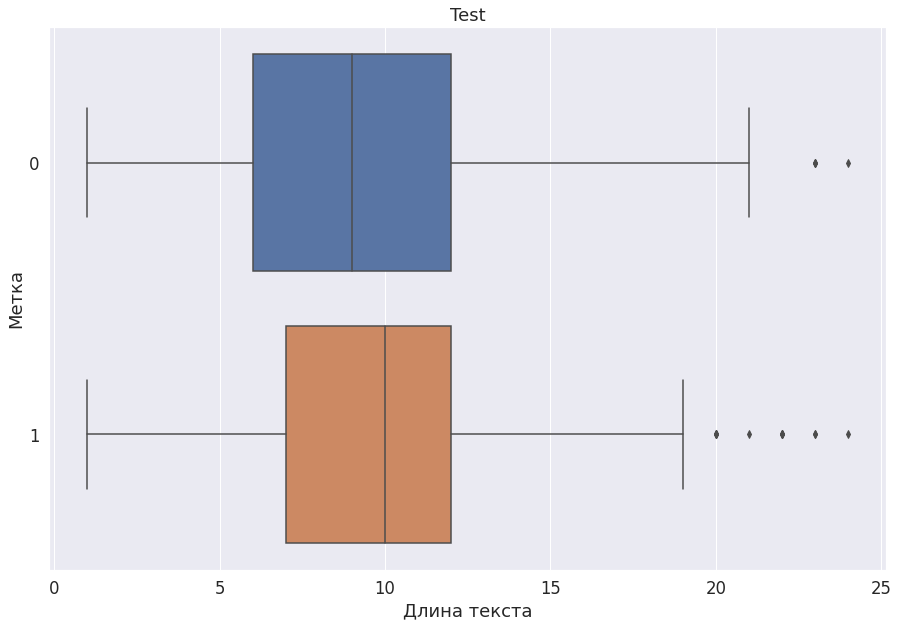

In [22]:
plt.figure(figsize=(15,10))
train_sent = train['text'].str.split().map(lambda x : len(x))
g = sns.boxplot(x=train_sent, y="target", data=train, orient='h',)
g.set(xlabel='Длина текста', ylabel='Метка')
g.set_title("Test")
plt.savefig( "boxplot_Test.png")
plt.show()

In [23]:
sentences = train_cleaned_data.text.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = train_cleaned_data.target.values  

In [24]:
sentences_test = test_cleaned_data.text.values
sentences_test = ["[CLS] " + sentence + " [SEP]" for sentence in sentences_test]

In [25]:
%%time
#lib_ = "garynguyen1174/disaster_tweet_bert"
#lib_ = "ReynaQuita/twitter_disaster_bert_large"
lib_ = 'bert-large-uncased'
#lib_ = "bert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(lib_)
tokenized_sentences = [tokenizer.tokenize(sent) for sent in tqdm(sentences)]
tokenized_sentences_test = [tokenizer.tokenize(sent) for sent in tqdm(sentences_test)]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

CPU times: user 9.89 s, sys: 236 ms, total: 10.1 s
Wall time: 16.4 s


In [26]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenized_sentences)]
input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenized_sentences_test)]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

In [27]:
token_lens = [len(sent) for sent in tqdm(input_ids)]
token_lens_test = [len(sent) for sent in tqdm(input_ids_test)]


  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

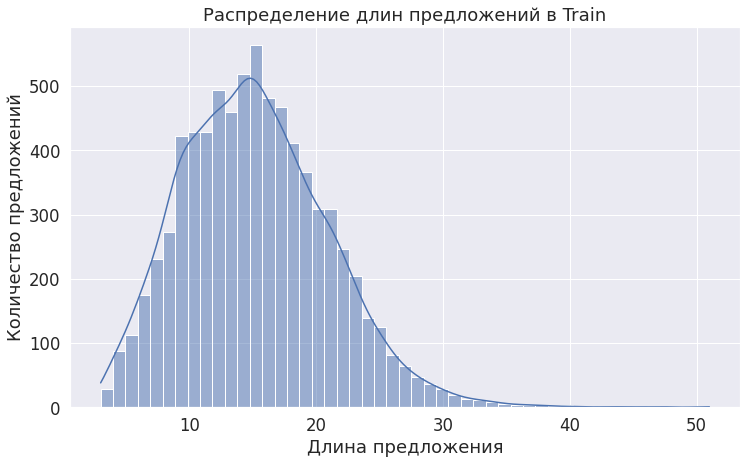

In [28]:
plt.figure(figsize=(12,7))

f = sns.histplot(token_lens, kde=True, bins=49)
plt.xlabel('Длина предложения')
plt.ylabel('Количество предложений')
plt.title('Распределение длин предложений в Train')
plt.savefig( "lensent_Train.png")
plt.show()

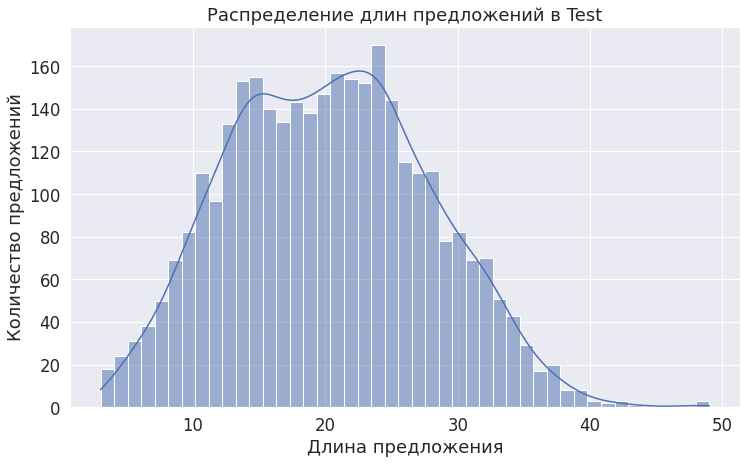

In [29]:
plt.figure(figsize=(12,7))

f = sns.histplot(token_lens_test, kde=True, bins=45)
plt.xlabel('Длина предложения')
plt.ylabel('Количество предложений')
plt.title('Распределение длин предложений в Test')
plt.savefig( "lensent_Test.png")

plt.show()

In [30]:
tokenizer.convert_tokens_to_ids("[PAD]")

0

In [31]:
# выберем максимальную длину предложения
MAX_LEN = 51

padding = lambda texts: pad_sequences(texts, 
                                      maxlen=MAX_LEN, 
                                      dtype="long", 
                                      truncating="post", 
                                      padding="post"
                                     )

# применяем padding и truncation ко входным данным
input_ids = padding(input_ids)
input_ids_test = padding(input_ids_test)

In [32]:
random_tweet = train_cleaned_data.text.sample(1).values[0]
random_tweet

'dogs lightning reshape rock atomic level lightning strike reshape mineral crystal structure'

In [33]:
example_sent = random_tweet
example_sent = "[CLS] " + example_sent + " [SEP]"
print("Предложение:", example_sent)
print("Токенизация:", tokenizer.tokenize(example_sent))

Предложение: [CLS] dogs lightning reshape rock atomic level lightning strike reshape mineral crystal structure [SEP]
Токенизация: ['[CLS]', 'dogs', 'lightning', 'res', '##ha', '##pe', 'rock', 'atomic', 'level', 'lightning', 'strike', 'res', '##ha', '##pe', 'mineral', 'crystal', 'structure', '[SEP]']


In [34]:
print("Предложение:", example_sent)
example_sent_ids = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(example_sent))
print("После padding:", padding([example_sent_ids]))

Предложение: [CLS] dogs lightning reshape rock atomic level lightning strike reshape mineral crystal structure [SEP]
После padding: [[  101  6077  7407 24501  3270  5051  2600  9593  2504  7407  4894 24501
   3270  5051  9754  6121  3252   102     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]]


In [35]:
get_attention_masks = lambda input_ids: [[float(i>0) for i in seq] for seq in input_ids]
get_attention_masks_test = lambda input_ids_test: [[float(i>0) for i in seq] for seq in input_ids_test]
attention_masks = get_attention_masks(input_ids)
attention_masks_test = get_attention_masks_test(input_ids_test)

In [36]:
print("Пример:")
print("Предложение:", example_sent)
example_sent_ids = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(example_sent))
print("После токенизации (индексы):", example_sent_ids)
example_sent_ids = padding([example_sent_ids])
print("После padding:", example_sent_ids)
print("Attention mask:", get_attention_masks(example_sent_ids))

Пример:
Предложение: [CLS] dogs lightning reshape rock atomic level lightning strike reshape mineral crystal structure [SEP]
После токенизации (индексы): [101, 6077, 7407, 24501, 3270, 5051, 2600, 9593, 2504, 7407, 4894, 24501, 3270, 5051, 9754, 6121, 3252, 102]
После padding: [[  101  6077  7407 24501  3270  5051  2600  9593  2504  7407  4894 24501
   3270  5051  9754  6121  3252   102     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0]]
Attention mask: [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


In [55]:
X_train, X_test, mask_train, mask_test, y_train, y_test = train_test_split(input_ids, 
                                                                           attention_masks, 
                                                                           labels, 
                                                                           test_size=0.3)

In [56]:
X_train, X_val, mask_train, mask_val, y_train, y_val = train_test_split(X_train,
                                                                        mask_train, 
                                                                        y_train, 
                                                                        test_size=0.1)

In [57]:
X_train = torch.tensor(X_train)
X_val = torch.tensor(X_val)
X_test_input = torch.tensor(input_ids_test)
X_train_all = torch.tensor(input_ids)
X_test = torch.tensor(X_test)

mask_train = torch.tensor(mask_train)
mask_val = torch.tensor(mask_val)
mask_test_input = torch.tensor(attention_masks_test)
mask_train_all = torch.tensor(attention_masks)
mask_test = torch.tensor(mask_test)

y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
y_test = torch.tensor(y_test)
y_train_all = torch.tensor(labels)

In [59]:
batch_size = 16

train_data = TensorDataset(X_train, mask_train, y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(X_val, mask_val, y_val)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


train_all_data = TensorDataset(X_train_all, mask_train_all, y_train_all)
train_all_sampler = SequentialSampler(train_all_data)
train_all_dataloader = DataLoader(train_all_data, sampler=train_all_sampler, batch_size=batch_size)

test_data = TensorDataset(X_test, mask_test, y_test)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [60]:
custom_model = BertForSequenceClassification.from_pretrained(
    lib_, num_labels=2
)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

In [61]:
custom_model = custom_model.to(device)

In [62]:
optimizer = AdamW(custom_model.parameters(), lr=2e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [63]:
def plot_learning_curves(history):
    sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20,7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [64]:
def train(
    model,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=50
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in tqdm(range(num_epochs), desc='epochs'):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        model.train(True) # устанавливаем поведение dropout / batch_norm  в обучение

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, mask_batch, y_batch in tqdm(
            train_batch_gen, desc='train sample batches'
        ):
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            mask_batch = mask_batch.to(device)
            y_batch = y_batch.to(device)
            
            model_output = model(X_batch, mask_batch, labels=y_batch)
            loss = model_output.loss
            logits = model_output.logits
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        model.train(False) # устанавливаем поведение dropout / batch_norm  в тестирование

        # Полный проход по валидации    
        for X_batch, mask_batch, y_batch in tqdm(
            val_batch_gen, desc='validation sample batches'
        ):
            X_batch = X_batch.to(device)
            mask_batch = mask_batch.to(device)
            y_batch = y_batch.to(device)
            
            # При использовании .no_grad() модель не будет считать и хранить градиенты.
            # Это ускорит процесс предсказания меток для тестовых данных.
            with torch.no_grad():
                model_output = model(X_batch, mask_batch, labels=y_batch)
                loss = model_output.loss
                logits = model_output.logits
            
            val_loss += np.sum(loss.detach().cpu().numpy())
            
            # применяем функцию max к каждому логиту из батча
            # функция max возвращает две величины: значения и индексы
            # выбираем индексы
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        if epoch > 0:
          plot_learning_curves(history)
        
    return model, history

Epoch 5 of 5 took 439.185s
  training loss (in-iteration): 	0.177802
  validation loss (in-iteration): 	0.615434
  training accuracy: 			93.21 %
  validation accuracy: 			82.54 %


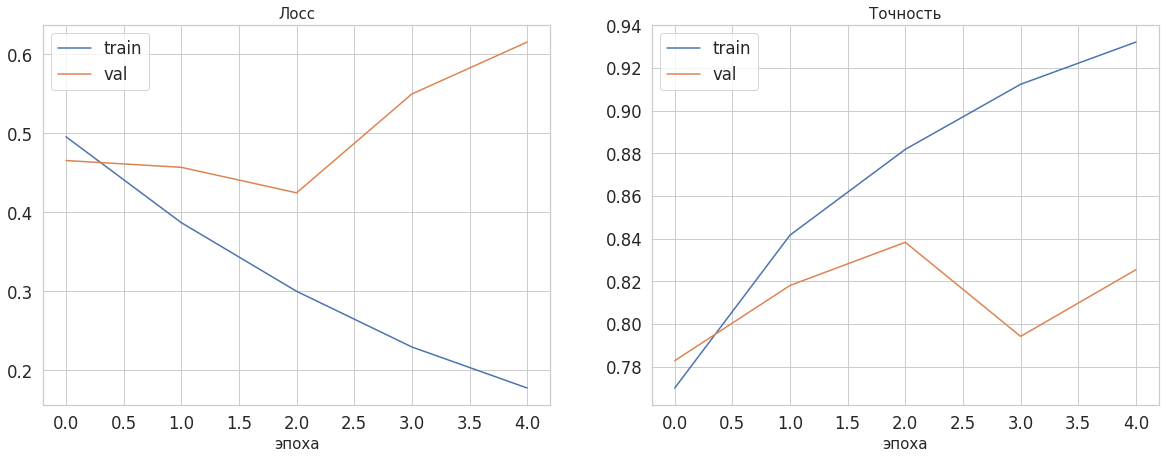

CPU times: user 21min 42s, sys: 14min 52s, total: 36min 34s
Wall time: 36min 38s


In [65]:
%%time
custom_model, history = train(
    custom_model, optimizer, 
    train_dataloader, val_dataloader, 
    num_epochs=5
)

In [66]:
test_data_input = TensorDataset(X_test_input, mask_test_input)
test_sampler_intput = SequentialSampler(test_data_input)
test_dataloader_intput = DataLoader(test_data_input, sampler=test_sampler_intput, batch_size=batch_size)

In [67]:
custom_model.eval()
test_preds, test_labels = [], []

for X_batch, mask_batch in tqdm(test_dataloader_intput):
    X_batch = X_batch.to(device)
    mask_batch = mask_batch.to(device)
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = custom_model(X_batch, mask_batch).logits
        
    # применяем функцию max к каждому логиту из батча
    # функция max возвращает две величины: значения и индексы
    # выбираем индексы
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    
    test_preds.extend(y_pred)

  0%|          | 0/204 [00:00<?, ?it/s]

In [68]:
custom_model.eval()
train_preds, train_labels = [], []

for X_batch, mask_batch, y_batch in tqdm(test_dataloader):
    X_batch = X_batch.to(device)
    mask_batch = mask_batch.to(device)
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = custom_model(X_batch, mask_batch).logits
        
    # применяем функцию max к каждому логиту из батча
    # функция max возвращает две величины: значения и индексы
    # выбираем индексы
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    
    train_preds.extend(y_pred)
    train_labels.extend(y_batch.numpy())

  0%|          | 0/143 [00:00<?, ?it/s]

In [69]:
def conf_matrix_plot(y_true, y_pred):
    plt.figure(figsize=(10,8))
    f = sns.heatmap(
        confusion_matrix(y_true, y_pred), 
        annot=True,
        fmt='.4g', 
        cmap='RdGy', 
        #linewidths=3, 
        #linecolor='black'б
        )
    plt.title('\nConfusion Matrix для Train\n', fontsize=25);
    plt.xlabel('Предсказанные значения', fontsize=15)
    plt.ylabel('Реальные значения', fontsize=15);
    plt.savefig( "confusion_matrix.png")

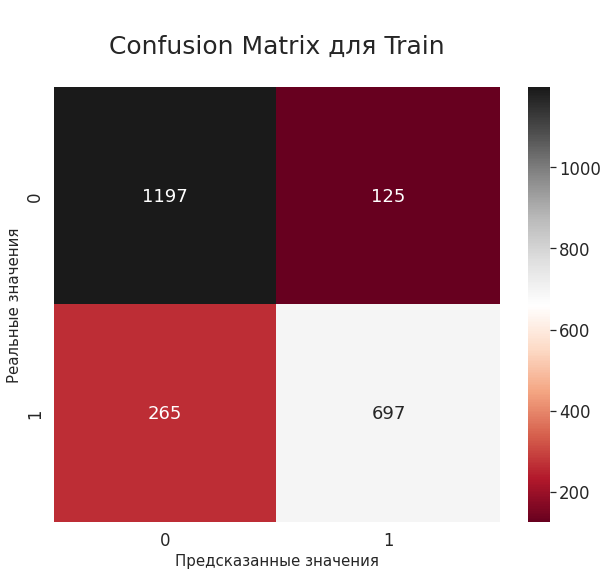

In [70]:
conf_matrix_plot(train_labels, train_preds)

In [71]:
submission = pd.DataFrame({'Id':test.id, 'target': test_preds})
submission.to_csv('submission.csv', index=False)
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "bert-large-uncased (5 epoch)"

100% 22.2k/22.2k [00:01<00:00, 16.6kB/s]
400 - Bad Request


In [72]:
print('Accuracy: {0:.2f}%, Precision: {1:.2f}%, Recall: {2:.2f}%, F1-score: {3:.2f}%'.format(
    accuracy_score(train_labels, train_preds) * 100,
    precision_score(train_labels, train_preds) * 100,
    recall_score(train_labels, train_preds) * 100,
    f1_score(train_labels, train_preds) * 100
))

Accuracy: 82.92%, Precision: 84.79%, Recall: 72.45%, F1-score: 78.14%
